In [1]:
from paretoKnapsackInfluence import *

import shutil
import matplotlib as mpl

# Enable LaTeX rendering if available (fallback to Matplotlib text otherwise)
if shutil.which("latex"):
    mpl.rcParams.update({
        "text.usetex": True,
        "font.family": "serif",
        "text.latex.preamble": r"\usepackage{amsmath}\usepackage{amssymb}",
    })
else:
    mpl.rcParams.update({"text.usetex": False})

# Import influence datasets
data_path_HEPT = '../../datasets/raw_data/influence/NetHEPT/hep.txt'
data_path_PHY = '../../datasets/raw_data/influence/NetPHY/phy.txt'

G_HEPT, node_costs_HEPT = import_influence_data(data_path_HEPT)
G_PHY, node_costs_PHY = import_influence_data(data_path_PHY)

2026-02-06 18:41:19,811 |INFO: Imported influence graph with 354 nodes and 840 edges
2026-02-06 18:41:21,409 |INFO: Imported influence graph with 151 nodes and 735 edges


In [2]:
def findApproximateParetoSolutionsKnapsackInfluence(G, node_costs, maxBudget, num_samples=35, num_runs=10, dataset_name=""):
    '''
    Run algorithms over multiple runs and plot mean +/- std (Influence vs Cost).
    Parameters:
    - G: Graph
    - node_costs: Node costs dict
    - maxBudget: Maximum knapsack budget
    - num_samples: Number of Monte Carlo samples per run
    - num_runs: Number of independent runs
    - dataset_name: Name of the dataset for plotting
    '''
    # Cost grid (same pattern as restaurants notebook)
    num_steps, min_cost = 10, 1
    cost_arr = np.linspace(min_cost, maxBudget, num_steps)

    algo_names = ["ParetoGreedy", "C-Greedy", "F-Greedy", "TopK"]

    def align_to_cost_arr(costs, infls):
        if len(costs) == 0:
            return np.zeros_like(cost_arr, dtype=float)
        costs = np.array(costs, dtype=float)
        infls = np.array(infls, dtype=float)
        return np.interp(cost_arr, costs, infls, left=infls[0], right=infls[-1])

    # containers across runs
    all_influences = {alg: [] for alg in algo_names}
    all_runtimes = {alg: [] for alg in algo_names}
    pareto_costs_all = []
    pareto_points_counts = []

    # frontier size counts per run
    pareto_size_counts = []
    fgreedy_size_counts = []
    cgreedy_size_counts = []
    topk_size_counts = []

    for _ in range(num_runs):
        # Generate graph samples once to share across algorithms (per run)
        graph_samples = []
        for _ in range(num_samples):
            G_sample = nx.Graph()
            neighbors = defaultdict(set)
            connected_components = defaultdict()
            for u, v, data in G.edges(data=True):
                success = np.random.uniform(0, 1)
                if success < data['weight']:
                    G_sample.add_edge(u, v)
                    neighbors[u].add(v)
                    neighbors[v].add(u)
            for c in nx.connected_components(G_sample):
                for node in c:
                    connected_components[node] = c
            graph_samples.append((G_sample, neighbors, connected_components))

        run_influences = {alg: [] for alg in algo_names}
        run_runtimes = {alg: [] for alg in algo_names}

        cgreedy_run_infls = []
        topk_run_infls = []

        # Run algorithms over budgets
        for budgetVal in cost_arr:
            pareto = paretoKnapsackInfluence(G=G,
                                             node_costs=node_costs,
                                             budget=budgetVal,
                                             num_samples=num_samples,
                                             graph_samples=graph_samples)

            # C-Greedy (replacement for C-Greedy-1)
            _, infl, cost, runTime = pareto.oneGuessGreedyPlus()
            run_influences['C-Greedy'].append(infl)
            run_runtimes['C-Greedy'].append(runTime)
            cgreedy_run_infls.append(infl)

            # Top-k (add nodes until budget is hit)
            _, infl, cost, runTime = pareto.top_k()
            run_influences['TopK'].append(infl)
            run_runtimes['TopK'].append(runTime)
            topk_run_infls.append(infl)

        cgreedy_size_counts.append(len(cgreedy_run_infls))
        topk_size_counts.append(len(topk_run_infls))

        # Pareto Greedy + Coverage Linear (computed once per run at full budget)
        pareto_full = paretoKnapsackInfluence(G=G,
                                              node_costs=node_costs,
                                              budget=maxBudget,
                                              num_samples=num_samples,
                                              graph_samples=graph_samples)

        pg1_costs, pg1_influences, _, pg1_time = pareto_full.prefixParetoGreedy_1Guess()
        cl_costs, cl_influences, _, cl_time = pareto_full.F_Greedy()

        run_influences['ParetoGreedy'] = list(align_to_cost_arr(pg1_costs, pg1_influences))
        run_runtimes['ParetoGreedy'].append(pg1_time)
        pareto_costs_all.extend(pg1_costs)
        pareto_points_counts.append(len(pg1_costs))
        pareto_size_counts.append(len(pg1_influences))

        run_influences['F-Greedy'] = list(align_to_cost_arr(cl_costs, cl_influences))
        run_runtimes['F-Greedy'].append(cl_time)
        fgreedy_size_counts.append(len(cl_influences))

        # store per-run arrays and total runtimes
        for alg in algo_names:
            arr = np.array(run_influences[alg], dtype=float)
            if arr.size == 0:
                arr = np.zeros_like(cost_arr, dtype=float)
            all_influences[alg].append(arr)
            runtimes = run_runtimes.get(alg, [])
            total_runtime = float(np.nansum(np.array(runtimes, dtype=float))) if len(runtimes) > 0 else 0.0
            all_runtimes[alg].append(total_runtime)

    # compute mean and std across runs for each algorithm
    mean_influences = {}
    std_influences = {}

    for alg in algo_names:
        stacked = np.vstack(all_influences[alg])  # shape (num_runs, len(cost_arr))
        mean_influences[alg] = np.mean(stacked, axis=0)
        std_influences[alg] = np.std(stacked, axis=0)

    mean_pareto_points = float(np.mean(pareto_points_counts)) if len(pareto_points_counts) > 0 else 0.0
    mean_pareto_size = float(np.mean(pareto_size_counts)) if len(pareto_size_counts) > 0 else 0.0
    mean_fgreedy_size = float(np.mean(fgreedy_size_counts)) if len(fgreedy_size_counts) > 0 else 0.0
    mean_cgreedy_size = float(np.mean(cgreedy_size_counts)) if len(cgreedy_size_counts) > 0 else 0.0
    mean_topk_size = float(np.mean(topk_size_counts)) if len(topk_size_counts) > 0 else 0.0

    def sample_scatter_costs(mean_points, rng):
        if cost_arr.size == 0 or mean_points <= 0:
            return np.array([], dtype=float)
        target_count = int(np.clip(np.round(mean_points), 1, cost_arr.size))
        base_idx = np.linspace(0, cost_arr.size - 1, target_count)
        base_idx = np.round(base_idx).astype(int)
        jitter = rng.integers(-1, 2, size=target_count)
        idx = np.clip(base_idx + jitter, 0, cost_arr.size - 1)
        idx = np.unique(idx)
        if idx.size < target_count:
            remaining = np.setdiff1d(np.arange(cost_arr.size), idx)
            if remaining.size > 0:
                extra = rng.choice(remaining, size=min(target_count - idx.size, remaining.size), replace=False)
                idx = np.sort(np.concatenate([idx, extra]))
        return cost_arr[idx]

    # Plot mean influence with shaded std band (consistent with teams formatting)
    tab10_colors = plt.get_cmap("tab10").colors
    color_map = {
        "TopK": tab10_colors[4],
        "C-Greedy": tab10_colors[1],
        "F-Greedy": tab10_colors[2],
        "ParetoGreedy": tab10_colors[3],
    }
    marker_map = {
        "TopK": "o",
        "F-Greedy": "s",
        "C-Greedy": "^",
        "ParetoGreedy": "X",
    }
    linestyle_map = {
        "TopK": (0, (1, 1)),
        "F-Greedy": (0, (2, 2)),
        "C-Greedy": (0, (3, 2)),
        "ParetoGreedy": (0, (4, 2)),
    }

    fig, ax = plt.subplots(figsize=(9, 5.5))
    rng = np.random.default_rng()
    for i, alg in enumerate(algo_names):
        mean = mean_influences[alg]
        std = std_influences[alg] * 0.5
        is_pareto = alg in {"ParetoGreedy"}
        marker_size = 7
        if is_pareto:
            marker_size = marker_size * 1.1
        line_style = linestyle_map.get(alg, (0, (1, 1)))

        color = color_map.get(alg, tab10_colors[i % len(tab10_colors)])
        marker = marker_map.get(alg, 'o')
        zorder = 3
        if alg == "ParetoGreedy":
            zorder = 4

        label = rf"\texttt{{{alg}}}"
        if is_pareto:
            ax.plot(cost_arr, mean,
                    label="_nolegend_",
                    color=color,
                    linestyle=line_style,
                    linewidth=1.8,
                    zorder=zorder)
            scatter_costs = sample_scatter_costs(mean_pareto_points, rng)
            if scatter_costs.size > 0:
                scatter_mean_vals = np.interp(scatter_costs, cost_arr, mean)
                ax.scatter(scatter_costs, scatter_mean_vals,
                           label="_nolegend_",
                           color=color,
                           marker=marker,
                           s=(marker_size * 1.1) ** 2,
                           linewidths=0,
                           zorder=zorder + 1)
        else:
            ax.plot(cost_arr, mean,
                    label=label,
                    color=color,
                    linestyle=line_style,
                    marker=marker,
                    markersize=marker_size,
                    markeredgewidth=0,
                    markeredgecolor='none',
                    linewidth=1.8,
                    zorder=zorder)
        ax.fill_between(cost_arr,
                        np.clip(mean - std, 0, None),
                        mean + std,
                        color=color,
                        alpha=0.18,
                        zorder=2)

    ax.set_xlabel(r'Seed cost, $c_\ell$', fontsize=28)
    ax.set_ylabel(r'Expected influence, $f$', fontsize=28)
    ax.set_title("")
    ax.grid(alpha=0.3)
    ax.tick_params(axis='both', labelsize=24)

    # Save figure
    from pathlib import Path
    base_dir = Path.cwd().resolve().parents[1]
    plots_dir = base_dir / "plots" / "knapsack"
    plots_dir.mkdir(parents=True, exist_ok=True)
    safe_name = (dataset_name or "dataset").replace(" ", "_")
    out_path = plots_dir / f"{safe_name}_knapsack.pdf"
    fig.savefig(out_path, bbox_inches="tight")

    plt.show()

    # Runtime summary (latex row)
    dataset_label = dataset_name or "dataset"
    dataset_macro_map = {
        "NetHEPT": r"\NetHEPT",
        "NetPHY": r"\NetPHY",
    }
    dataset_macro = dataset_macro_map.get(dataset_label, rf"\\dataset{{{dataset_label}}}")
    mean_cgreedy_rt = float(np.mean(all_runtimes['C-Greedy'])) if len(all_runtimes['C-Greedy']) > 0 else 0.0
    mean_fgreedy_rt = float(np.mean(all_runtimes['F-Greedy'])) if len(all_runtimes['F-Greedy']) > 0 else 0.0
    mean_pareto_rt = float(np.mean(all_runtimes['ParetoGreedy'])) if len(all_runtimes['ParetoGreedy']) > 0 else 0.0
    mean_topk_rt = float(np.mean(all_runtimes['TopK'])) if len(all_runtimes['TopK']) > 0 else 0.0
    runtime_row = (
        f"{dataset_macro} "
        f"& {mean_cgreedy_rt:.3f} "
        f"& {mean_fgreedy_rt:.3f} "
        f"& -- "
        f"& {mean_pareto_rt:.3f} "
        f"& {mean_topk_rt:.3f} \\\\" 
    )
    logging.info(runtime_row)

    # Mean frontier sizes summary (latex row)
    frontier_row = (
        f"{dataset_macro} "
        f"& {mean_cgreedy_size:.3f} "
        f"& {mean_fgreedy_size:.3f} "
        f"& -- "
        f"& {mean_pareto_size:.3f} "
        f"& {mean_topk_size:.3f} \\\\" 
    )
    logging.info(frontier_row)

    summary_dir = plots_dir / "summary"
    summary_dir.mkdir(parents=True, exist_ok=True)
    runtimes_path = summary_dir / "runtimes.txt"
    frontier_path = summary_dir / "frontier-size.txt"
    with open(runtimes_path, "a", encoding="utf-8") as runtime_file:
        runtime_file.write(runtime_row + "\n")
    with open(frontier_path, "a", encoding="utf-8") as frontier_file:
        frontier_file.write(frontier_row + "\n")

### NetHEPT Experiments

In [ ]:
# Parameters
maxBudget = 200
num_samples = 3
num_runs = 2

# Run for NetHEPT
findApproximateParetoSolutionsKnapsackInfluence(
    G_HEPT,
    node_costs_HEPT,
    maxBudget,
    num_samples=num_samples,
    num_runs=num_runs,
    dataset_name="NetHEPT"
)

### NetPHY Experiments

2026-02-06 18:59:27,355 |INFO: Initialized Pareto Influence - Knapsack Cost Instance, Num Nodes:151, Budget=1.0
2026-02-06 18:59:27,357 |INFO: Initialized Pareto Influence - Knapsack Cost Instance, Num Nodes:151, Budget=14.777777777777779
2026-02-06 18:59:27,571 |INFO: Initialized Pareto Influence - Knapsack Cost Instance, Num Nodes:151, Budget=28.555555555555557
2026-02-06 18:59:27,831 |INFO: Initialized Pareto Influence - Knapsack Cost Instance, Num Nodes:151, Budget=42.333333333333336
2026-02-06 18:59:28,387 |INFO: Initialized Pareto Influence - Knapsack Cost Instance, Num Nodes:151, Budget=56.111111111111114
2026-02-06 18:59:29,102 |INFO: Initialized Pareto Influence - Knapsack Cost Instance, Num Nodes:151, Budget=69.88888888888889
2026-02-06 18:59:29,839 |INFO: Initialized Pareto Influence - Knapsack Cost Instance, Num Nodes:151, Budget=83.66666666666667
2026-02-06 18:59:30,638 |INFO: Initialized Pareto Influence - Knapsack Cost Instance, Num Nodes:151, Budget=97.44444444444446
20

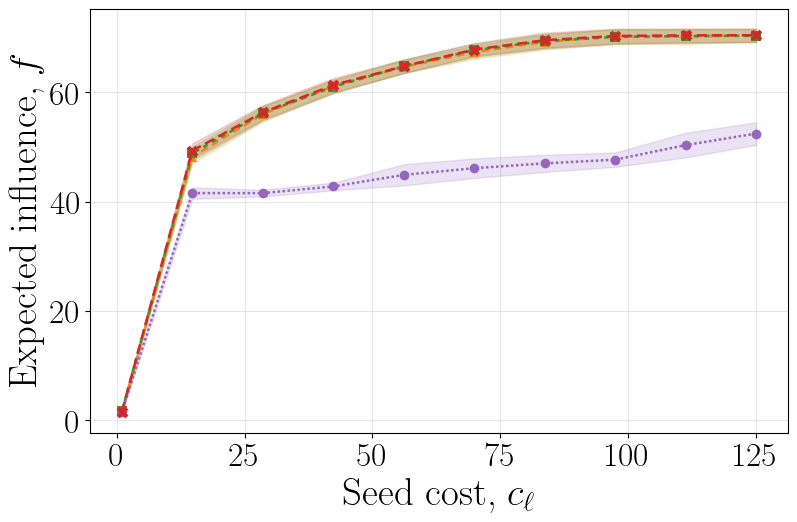

2026-02-06 19:00:41,054 |INFO: \NetPHY & 6.182 & 17.373 & -- & 0.895 & 0.020 \\
2026-02-06 19:00:41,055 |INFO: \NetPHY & 10.000 & 70.333 & -- & 43.000 & 10.000 \\


In [6]:
# Parameters
maxBudget = 125
num_samples = 3
num_runs = 3

# Run for NetPHY
findApproximateParetoSolutionsKnapsackInfluence(
    G_PHY,
    node_costs_PHY,
    maxBudget,
    num_samples=num_samples,
    num_runs=num_runs,
    dataset_name="NetPHY"
)